# NFL Competition

# Feature Engineering e Modelo de Machine Learning

## 1. Importa os pacotes e o dataset de treino

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import sklearn.metrics as mtr
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [2]:
# Importa os pacotes de algoritmos de regressão
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Importa os pacotes de algoritmos de redes neurais (Keras)
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping
from keras.layers import Dropout

# Importa pacotes do sklearn
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler

Using TensorFlow backend.


In [3]:
# Define o caminho do arquivo
path_local  = '../data/train.csv'
path_kernel = '/kaggle/input/nfl-big-data-bowl-2020/train.csv'

# Carrega o dataset de treino
train = pd.read_csv(path_local, usecols =['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis',
                                          'Orientation', 'Dir', 'NflId', 'DisplayName', 'YardLine',
                                          'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
                                          'FieldPosition', 'NflIdRusher', 'OffenseFormation', 
                                          'OffensePersonnel', 'DefendersInTheBox', 'DefensePersonnel', 
                                          'PlayDirection', 'TimeHandoff', 'TimeSnap', 'HomeTeamAbbr','VisitorTeamAbbr',
                                          'PlayerHeight','WindSpeed','PlayerBirthDate','Season','Yards'])

# Usado somente para teste (somente as primeiras 2200 linhas)
#train = train[:2200]

## 2. Feature Engineering

In [4]:
def create_features_01(df, deploy=False):
    def new_X(x_coordinate, play_direction):
        if play_direction == 'left':
            return 120.0 - x_coordinate
        else:
            return x_coordinate

    def new_line(rush_team, field_position, yardline):
        if rush_team == field_position:
            # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
            return 10.0 + yardline
        else:
            # half the field plus the yards between midfield and the line of scrimmage
            return 60.0 + (50 - yardline)

    def new_orientation(angle, play_direction):
        if play_direction == 'left':
            new_angle = 360.0 - angle
            if new_angle == 360.0:
                new_angle = 0.0
            return new_angle
        else:
            return angle

    def euclidean_distance(x1,y1,x2,y2):
        x_diff = (x1-x2)**2
        y_diff = (y1-y2)**2

        return np.sqrt(x_diff + y_diff)

    def back_direction(orientation):
        if orientation > 180.0:
            return 1
        else:
            return 0

    def update_yardline(df):
        new_yardline = df[df['NflId'] == df['NflIdRusher']]
        new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
        new_yardline = new_yardline[['GameId','PlayId','YardLine']]

        return new_yardline

    def update_orientation(df, yardline):
        df['X'] = df[['X','PlayDirection']].apply(lambda x: new_X(x[0],x[1]), axis=1)
        df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)

        df = df.drop('YardLine', axis=1)
        df = pd.merge(df, yardline, on=['GameId','PlayId'], how='inner')

        return df

    def back_features(df):
        carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
        carriers['back_from_scrimmage'] = carriers['YardLine'] - carriers['X']
        carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
        carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
        carriers = carriers.rename(columns={'X':'back_X',
                                            'Y':'back_Y'})
        carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y','back_from_scrimmage','back_oriented_down_field','back_moving_down_field']]

        return carriers

    def features_relative_to_back(df, carriers):
        player_distance = df[['GameId','PlayId','NflId','X','Y']]
        player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
        player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
        player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        player_distance = player_distance.groupby(['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field'])\
                                         .agg({'dist_to_back':['min','max','mean','std']})\
                                         .reset_index()
        player_distance.columns = ['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field',
                                   'min_dist','max_dist','mean_dist','std_dist']

        return player_distance

    def defense_features(df):
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','X','Y']]
        rusher.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

        defense = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')
        defense = defense[defense['Team'] != defense['RusherTeam']][['GameId','PlayId','X','Y','RusherX','RusherY']]
        defense['def_dist_to_back'] = defense[['X','Y','RusherX','RusherY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        defense = defense.groupby(['GameId','PlayId'])\
                         .agg({'def_dist_to_back':['min','max','mean','std']})\
                         .reset_index()
        defense.columns = ['GameId','PlayId','def_min_dist','def_max_dist','def_mean_dist','def_std_dist']

        return defense

    def static_features(df):
        static_features = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','X','Y','S','A','Dis','Orientation','Dir',
                                                               'YardLine','Quarter','Down','Distance','DefendersInTheBox','Team',
                                                               'PossessionTeam','HomeTeamAbbr','VisitorTeamAbbr','FieldPosition',
                                                               'PlayDirection','PlayerHeight','WindSpeed','NflId','NflIdRusher',
                                                               'TimeHandoff','TimeSnap','PlayerBirthDate','GameClock','Season']].drop_duplicates()
        static_features['DefendersInTheBox'] = static_features['DefendersInTheBox'].fillna(np.mean(static_features['DefendersInTheBox']))

        return static_features

    def split_personnel(s):
        splits = s.split(',')
        for i in range(len(splits)):
            splits[i] = splits[i].strip()

        return splits

    def defense_formation(l):
        dl = 0
        lb = 0
        db = 0
        other = 0

        for position in l:
            sub_string = position.split(' ')
            if sub_string[1] == 'DL':
                dl += int(sub_string[0])
            elif sub_string[1] in ['LB','OL']:
                lb += int(sub_string[0])
            else:
                db += int(sub_string[0])

        counts = (dl,lb,db,other)

        return counts

    def offense_formation(l):
        qb = 0
        rb = 0
        wr = 0
        te = 0
        ol = 0

        sub_total = 0
        qb_listed = False
        for position in l:
            sub_string = position.split(' ')
            pos = sub_string[1]
            cnt = int(sub_string[0])

            if pos == 'QB':
                qb += cnt
                sub_total += cnt
                qb_listed = True
            # Assuming LB is a line backer lined up as full back
            elif pos in ['RB','LB']:
                rb += cnt
                sub_total += cnt
            # Assuming DB is a defensive back and lined up as WR
            elif pos in ['WR','DB']:
                wr += cnt
                sub_total += cnt
            elif pos == 'TE':
                te += cnt
                sub_total += cnt
            # Assuming DL is a defensive lineman lined up as an additional line man
            else:
                ol += cnt
                sub_total += cnt

        # If not all 11 players were noted at given positions we need to make some assumptions
        # I will assume if a QB is not listed then there was 1 QB on the play
        # If a QB is listed then I'm going to assume the rest of the positions are at OL
        # This might be flawed but it looks like RB, TE and WR are always listed in the personnel
        if sub_total < 11:
            diff = 11 - sub_total
            if not qb_listed:
                qb += 1
                diff -= 1
            ol += diff

        counts = (qb,rb,wr,te,ol)

        return counts    

    def personnel_features(df):
        personnel = df[['GameId','PlayId','OffensePersonnel','DefensePersonnel']].drop_duplicates()
        personnel['DefensePersonnel'] = personnel['DefensePersonnel'].apply(lambda x: split_personnel(x))
        personnel['DefensePersonnel'] = personnel['DefensePersonnel'].apply(lambda x: defense_formation(x))
        personnel['num_DL'] = personnel['DefensePersonnel'].apply(lambda x: x[0])
        personnel['num_LB'] = personnel['DefensePersonnel'].apply(lambda x: x[1])
        personnel['num_DB'] = personnel['DefensePersonnel'].apply(lambda x: x[2])

        personnel['OffensePersonnel'] = personnel['OffensePersonnel'].apply(lambda x: split_personnel(x))
        personnel['OffensePersonnel'] = personnel['OffensePersonnel'].apply(lambda x: offense_formation(x))
        personnel['num_QB'] = personnel['OffensePersonnel'].apply(lambda x: x[0])
        personnel['num_RB'] = personnel['OffensePersonnel'].apply(lambda x: x[1])
        personnel['num_WR'] = personnel['OffensePersonnel'].apply(lambda x: x[2])
        personnel['num_TE'] = personnel['OffensePersonnel'].apply(lambda x: x[3])
        personnel['num_OL'] = personnel['OffensePersonnel'].apply(lambda x: x[4])

        # Let's create some features to specify if the OL is covered
        personnel['OL_diff'] = personnel['num_OL'] - personnel['num_DL']
        personnel['OL_TE_diff'] = (personnel['num_OL'] + personnel['num_TE']) - personnel['num_DL']
        # Let's create a feature to specify if the defense is preventing the run
        # Let's just assume 7 or more DL and LB is run prevention
        personnel['run_def'] = (personnel['num_DL'] + personnel['num_LB'] > 6).astype(int)

        personnel.drop(['OffensePersonnel','DefensePersonnel'], axis=1, inplace=True)
        
        return personnel

    def combine_features(relative_to_back, defense, static, personnel, deploy=deploy):
        df = pd.merge(relative_to_back,defense,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,static,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,personnel,on=['GameId','PlayId'],how='inner')

        if not deploy:
            df = pd.merge(df, outcomes, on=['GameId','PlayId'], how='inner')

        return df

    yardline = update_yardline(df)
    df = update_orientation(df, yardline)
    back_feats = back_features(df)
    rel_back = features_relative_to_back(df, back_feats)
    def_feats = defense_features(df)
    static_feats = static_features(df)
    personnel = personnel_features(df)
    
    basetable = combine_features(rel_back, def_feats, static_feats, personnel, deploy=deploy)
    
    return basetable


def get_time(x):
    x = x.split(":")
    return int(x[0])*60 + int(x[1])

def get_height(x):
    x = x.split("-")
    return int(x[0])*12 + int(x[1])

def process_windspeed(txt):
    txt = str(txt).lower().replace('mph', '').strip()
    if '-' in txt:
        txt = (int(txt.split('-')[0]) + int(txt.split('-')[1])) / 2
    try:
        return float(txt)
    except:
        return -1.0

def create_features_02(t_):
    t_['fe1'] = pd.Series(np.sqrt(np.absolute(np.square(t_.X.values) - np.square(t_.Y.values))))
    t_['fe5'] = np.square(t_['S'].values) + 2 * t_['A'].values * t_['Dis'].values  # N
    t_['fe7'] = np.arccos(np.clip(t_['X'].values / t_['Y'].values, -1, 1))  # N
    t_['fe8'] = t_['S'].values / np.clip(t_['fe1'].values, 0.6, None)
    radian_angle = (90 - t_['Dir']) * np.pi / 180.0
    t_['fe10'] = np.abs(t_['S'] * np.cos(radian_angle))
    t_['fe11'] = np.abs(t_['S'] * np.sin(radian_angle))
    
    t_["is_rusher"]          = 1.0*(t_["NflId"] == t_["NflIdRusher"])
    t_["is_home"]            = t_["Team"] == "home"
    t_["is_possession_team"] = 1.0*(t_["PossessionTeam"] == t_["HomeTeamAbbr"]) - 1.0*(t_["PossessionTeam"] == t_["VisitorTeamAbbr"])
    t_["is_field_team"]      = 1.0*(t_["FieldPosition"] == t_["HomeTeamAbbr"]) - 1.0*(t_["FieldPosition"] == t_["VisitorTeamAbbr"])
    t_["is_left"]            = t_["PlayDirection"] == "left"
    t_["player_height"]      = t_["PlayerHeight"].apply(get_height)

    t_["WindSpeed"]   = t_["WindSpeed"].apply(process_windspeed)
    t_["TimeHandoff"] = pd.to_datetime(t_["TimeHandoff"])
    t_["TimeSnap"]    = pd.to_datetime(t_["TimeSnap"])
    t_["duration"]    = (t_["TimeHandoff"] - t_["TimeSnap"]).dt.total_seconds()

    t_["player_age"]  = (t_["TimeSnap"].dt.date - pd.to_datetime(t_["PlayerBirthDate"]).dt.date)/np.timedelta64(1, 'D') / 365

    t_["game_time"]   = t_["GameClock"].apply(get_time)
    t_["old_data"]    = t_["Season"] == 2017
    return t_


def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

In [5]:
# Define as colunas ID que serão agrupadas e posteriormente removidas
outcomes = train[['GameId','PlayId','Yards']].drop_duplicates()

In [6]:
# Cria as novas features (etapa 01)
%time train_basetable = create_features_01(train, False)

CPU times: user 1min 18s, sys: 1.42 s, total: 1min 19s
Wall time: 1min 14s


In [7]:
# Cria as novas features (etapa 02)
%time train_basetable = create_features_02(train_basetable)

CPU times: user 2.29 s, sys: 56.8 ms, total: 2.34 s
Wall time: 2 s


In [8]:
# Cria as novas features (etapa 03)
log_features = ['X','Y','S','A','Dis','Orientation','Dir','YardLine','player_height','player_age','game_time']
train_basetable = logs(train_basetable, log_features)

In [9]:
# Cria as novas features (etapa 04)
squared_features = ['X','Y','S','A','Dis','Orientation','Dir','YardLine','player_height','player_age','game_time']
train_basetable = squares(train_basetable, squared_features)

In [10]:
# Remove algumas features do dataset e preenche valores NaN com 0 (zero)
train_basetable.drop(['TimeHandoff','PlayerBirthDate','GameClock','PlayerHeight','NflId','NflIdRusher'], axis=1, inplace=True)
train_basetable = train_basetable.fillna(0)

In [11]:
# Cria uma copia do dataset para backup
X = train_basetable.copy()
X.shape

(23171, 84)

In [12]:
# Transformação de variaveis categoricas para numericas usando LabelEncoder
le = preprocessing.LabelEncoder()

le_dict = {}
categoricals = ['Team_le','PossessionTeam_le','HomeTeamAbbr_le','VisitorTeamAbbr_le',
                'FieldPosition_le','PlayDirection_le','Season_le']

for cat in categoricals:
    le_dict[cat] = LabelEncoder()
    X[cat] = le_dict[cat].fit_transform(X[cat[:-3]].apply(str))  

# Remove as features originais que foram transformadas
X.drop(['TimeSnap','Team','PossessionTeam','HomeTeamAbbr','VisitorTeamAbbr','FieldPosition','PlayDirection','Season'], axis=1, inplace=True)

X.head()

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,DefendersInTheBox,WindSpeed,num_DL,num_LB,num_DB,num_QB,num_RB,num_WR,num_TE,num_OL,OL_diff,OL_TE_diff,run_def,Yards,fe1,fe5,fe7,fe8,fe10,fe11,is_rusher,is_home,is_possession_team,is_field_team,is_left,player_height,duration,player_age,game_time,old_data,X_log,Y_log,S_log,A_log,Dis_log,Orientation_log,Dir_log,YardLine_log,player_height_log,player_age_log,game_time_log,X_sq,Y_sq,S_sq,A_sq,Dis_sq,Orientation_sq,Dir_sq,YardLine_sq,player_height_sq,player_age_sq,game_time_sq,Team_le,PossessionTeam_le,HomeTeamAbbr_le,VisitorTeamAbbr_le,FieldPosition_le,PlayDirection_le,Season_le
0,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.593310,22.415872,9.752491,5.327299,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,6.0,8.0,2,3,6,1,1,3,1,5,3,4,0,8,27.739531,15.7229,0.0,0.130860,3.309436,1.491487,1.0,True,1.0,1.0,True,70,1.0,25.613699,854,True,3.743841,3.451257,1.534714,1.472472,0.329304,5.293456,4.747277,3.828859,4.262821,3.281802,6.751113,1701.5625,932.0809,13.1769,11.2225,0.1444,39211.9204,13055.3476,2025.0,4900,656.061558,729316,1,20,20,15,21,0,0
1,2017090700,20170907000139,4.07,0,0,0.792023,23.025872,8.614623,5.598683,4.287773,23.025872,10.297028,5.833217,48.93,27.16,3.06,2.41,0.34,149.30,47.80,53.0,1,1,10,6.0,8.0,2,3,6,1,1,3,1,5,3,4,0,3,40.699869,11.0024,0.0,0.075185,2.266862,2.055465,1.0,True,1.0,1.0,True,70,1.0,25.613699,832,True,3.910822,3.338258,1.403643,1.229641,0.300105,5.012700,3.887935,3.989169,4.262821,3.281802,6.725046,2394.1449,737.6656,9.3636,5.8081,0.1156,22290.4900,2284.8400,2809.0,4900,656.061558,692224,1,20,20,15,21,0,0
2,2017090700,20170907000189,3.66,1,0,1.646390,20.726285,8.482583,4.642121,4.221670,20.726285,9.903689,5.073290,71.34,19.11,5.77,2.42,0.60,219.18,138.04,75.0,1,1,10,7.0,8.0,2,3,6,1,1,3,1,5,3,4,0,5,68.732841,36.1969,0.0,0.083948,3.857889,4.290640,1.0,True,1.0,-1.0,True,70,2.0,25.613699,782,True,4.281515,3.001714,1.913977,1.232560,0.476234,5.394491,4.934834,4.330865,4.262821,3.281802,6.663145,5089.3956,365.1921,33.2929,5.8564,0.3600,48039.8724,19055.0416,5625.0,4900,656.061558,611524,1,20,20,15,16,0,0
3,2017090700,20170907000345,3.53,0,0,0.918096,9.791231,5.549379,1.983128,4.528002,9.791231,6.309354,1.834174,104.47,25.36,4.45,3.20,0.46,173.78,84.56,108.0,1,2,2,9.0,8.0,4,4,3,1,2,0,2,6,2,4,1,2,101.345209,22.7465,0.0,0.043909,4.429957,0.421875,1.0,True,1.0,-1.0,True,71,2.0,26.871233,732,True,4.658521,3.272227,1.697449,1.437463,0.385262,5.163585,4.449335,4.691440,4.276805,3.327954,6.597159,10913.9809,643.1296,19.8025,10.2400,0.2116,30199.4884,7150.3936,11664.0,5041,722.063156,535824,1,20,20,15,16,0,0
4,2017090700,20170907000395,5.01,0,0,0.502892,21.214806,9.168819,5.611232,4.288088,21.214806,11.056456,5.900009,29.99,27.12,3.90,2.53,0.44,34.27,157.92,35.0,1,1,10,7.0,8.0,3,2,6,1,1,1,3,5,2,5,0,7,12.802566,17.4364,0.0,0.304626,1.466013,3.613974,1.0,False,-1.0,-1.0,False,71,1.0,22.106849,728,True,3.433987,3.336837,1.591274,1.264127,0.371564,3.563316,5.068464,3.583797,4.276805,3.140562,6.591687,899.4001,735.4944,15.2100,6.4009,0.1936,1174.4329,24938.7264,1225.0,5041,488.712787,529984,0,15,20,15,16,1,0


## 3. Feature Selection

In [13]:
# Instalando o pacote LOFO para verificar as features mais importantes
# Não é possível utilizar na competição pois o Kernel não terá acesso a Internet
!pip install lofo-importance

In [14]:
# Procedimento para verificar as features mais importantes
# Usando LightGBM para treinamento
from lofo import LOFOImportance, Dataset, plot_importance

n_folds = 5
kfold = KFold(n_folds, shuffle=False, random_state=42)

features = ['back_from_scrimmage','back_oriented_down_field','back_moving_down_field','min_dist','max_dist','mean_dist',
            'std_dist','def_min_dist','def_max_dist','def_mean_dist','def_std_dist','X','Y','S','A','Dis','Orientation',
            'Dir','YardLine','Quarter','Down','Distance','DefendersInTheBox','WindSpeed','num_DL','num_LB','num_DB',
            'num_QB','num_RB','num_WR','num_TE','num_OL','OL_diff','OL_TE_diff','run_def',
            'fe1','fe5','fe7','fe8','fe10','fe11','is_rusher','is_home',
            'is_possession_team','is_field_team','is_left','player_height','duration','player_age','game_time','old_data',
            'X_log','Y_log','S_log','A_log','Dis_log','Orientation_log','Dir_log',
            'YardLine_log','player_height_log','player_age_log','game_time_log','X_sq','Y_sq','S_sq','A_sq','Dis_sq',
            'Orientation_sq','Dir_sq','YardLine_sq','player_height_sq','player_age_sq','game_time_sq','Team_le',
            'PossessionTeam_le','HomeTeamAbbr_le','VisitorTeamAbbr_le','FieldPosition_le','PlayDirection_le','Season_le']

params = {'num_leaves': 15,
          'objective': 'mae',
          'learning_rate': 0.1,
          "boosting": "gbdt",
          "num_rounds": 100
          }

model = lgb.LGBMRegressor(**params)

dataset = Dataset(df=X, target="Yards", features=features)

lofo_imp = LOFOImportance(dataset, model=model, cv=kfold, scoring="neg_mean_absolute_error", fit_params={"categorical_feature": categoricals})

importance_df = lofo_imp.get_importance()

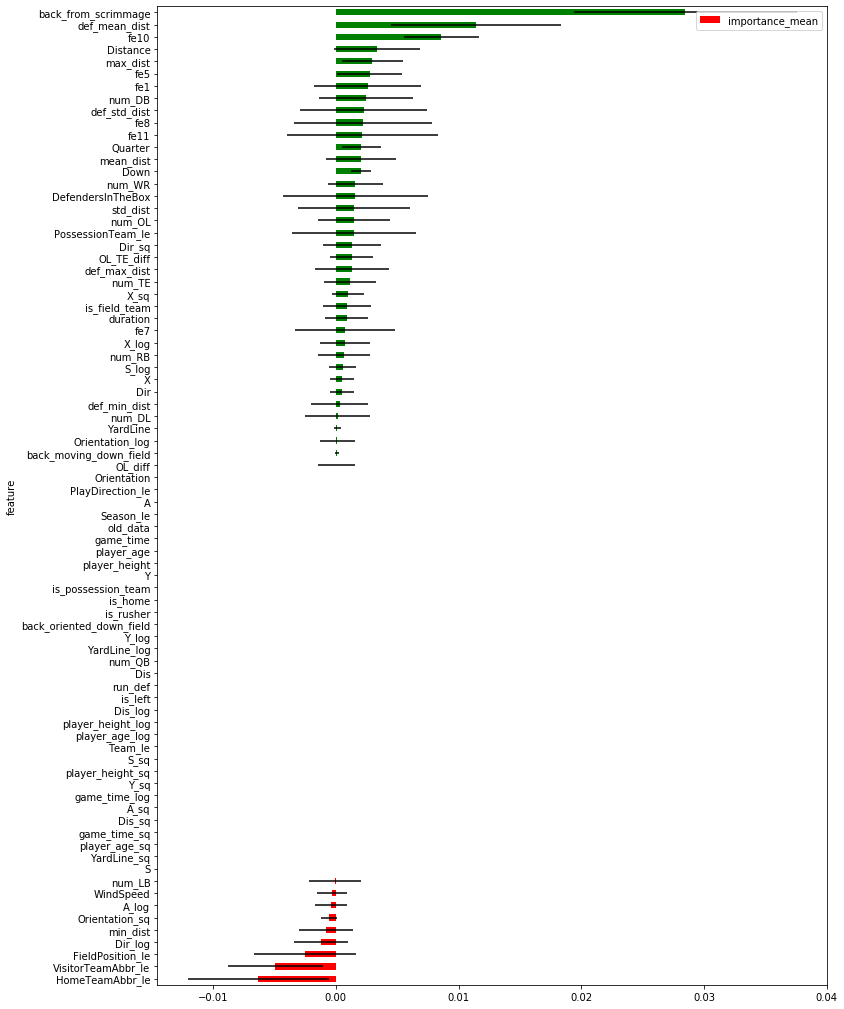

In [15]:
# Exibindo grafico com as features
plot_importance(importance_df, figsize=(12, 18))

## 4. Criar e avaliar alguns algoritmos de Machine Learning

## 4.1. Teste com Random Forest

In [16]:
# Criar um dataset somente com as colunas mais importantes conforme visto anteriormente
#new_X = X[['back_from_scrimmage','def_mean_dist','fe10','fe11','X_log','Dir','A_log','Down','def_min_dist','Quarter','is_field_team','num_WR','X_sq','is_possession_team','back_moving_down_field']]
new_X = X.copy()
target = X.Yards

y = np.zeros((target.shape[0], 199))
for idx, target in enumerate(list(target)):
    y[idx][99 + target] = 1

new_X.drop(['Yards','GameId','PlayId','TimeSnap','Team','PossessionTeam','HomeTeamAbbr','VisitorTeamAbbr','FieldPosition','PlayDirection','Season'], axis=1, inplace=True)
    
# Normalizando as variaveis do dataset de treino
scaler = StandardScaler()
new_X = scaler.fit_transform(new_X)

In [17]:
# Funcao para validacao do modelo conforme metrica da competicao (CRPS)
def crps(y_true, y_pred):
    y_true = np.clip(np.cumsum(y_true, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    return ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * y_true.shape[0]) 

In [18]:
# Definição do algoritmo Random Forest Regressor com alguns parametros configurados
rf = RandomForestRegressor(bootstrap=False, 
                           max_features=0.3, 
                           min_samples_leaf=15, 
                           min_samples_split=7, 
                           n_estimators=50, 
                           n_jobs=-1, 
                           random_state=42)

In [19]:
# Realizando o fit do modelo Random Forest Regressor
# Neste momento já realiza as predições com os dados de validação
# Guarda os scores para cada KFold
modelsRF = []
kf = KFold(n_splits=5, random_state=42)
score = []
for i, (tdx, vdx) in enumerate(kf.split(new_X, y)):
    print(f'Fold : {i}')
    X_train, X_val, y_train, y_val = new_X[tdx], new_X[vdx], y[tdx], y[vdx]
    rf.fit(X_train, y_train)
    score_ = crps(y_val, rf.predict(X_val))
    print(score_)
    score.append(score_)
    modelsRF.append(rf)

Fold : 0
0.01244383136202124
Fold : 1
0.012227903740664549
Fold : 2
0.011951408037993331
Fold : 3
0.01449924014629843
Fold : 4
0.014292172896267955


In [20]:
# Exibe o score médio de todos os KFolds
print(np.mean(score))

0.0130829112366491


## 4.2. Teste com Keras (Rede Neural MLP)

In [21]:
# Neste caso usaremos a tecnica de Split com a função train_test_split
# Vamos dividir usando 15% dos dados para validação
X_train, X_val, y_train, y_val = train_test_split(new_X, y, test_size=0.15, random_state=12345)

In [22]:
# Exibe o shape das matrizes
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(19695, 15) (3476, 15)
(19695, 199) (3476, 199)


In [23]:
# Classe com as funções para validar a métrica para cada passada (epoch) da rede neural
class Metric(Callback):
    def __init__(self, model, callbacks, data):
        super().__init__()
        self.model = model
        self.callbacks = callbacks
        self.data = data

    def on_train_begin(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_begin(logs)

    def on_train_end(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_end(logs)

    def on_epoch_end(self, batch, logs=None):
        X_train, y_train = self.data[0][0], self.data[0][1]
        y_pred = self.model.predict(X_train)
        y_true = np.clip(np.cumsum(y_train, axis=1), 0, 1)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
        tr_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_train.shape[0])
        tr_s = np.round(tr_s, 6)
        logs['tr_CRPS'] = tr_s

        X_valid, y_valid = self.data[1][0], self.data[1][1]

        y_pred = self.model.predict(X_valid)
        y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
        val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
        val_s = np.round(val_s, 6)
        logs['val_CRPS'] = val_s
        print('tr CRPS', tr_s, 'val CRPS', val_s)

        for callback in self.callbacks:
            callback.on_epoch_end(batch, logs)

In [24]:
# Criação do grafo para a rede neural (MLP)
# Usando Dropout para ajudar no controle do overfitting
model_nn = Sequential()
model_nn.add(Dense(512, input_dim=new_X.shape[1], activation='relu'))
model_nn.add(Dropout(0.4))
model_nn.add(Dense(256, activation='relu'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(256, activation='relu'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(199, activation='softmax'))

In [25]:
# Exibe um sumario da rede neural
model_nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 199)              

In [26]:
# Realizando a compilação da estrutura da rede neural
# Adicionado o tipo de otimizados (Adam), o metodo de perda do modelo e as metricas
model_nn.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[])

In [27]:
# Função para configurar a rede neural para parar o processo assim que identificar que não há mais ganho
# O parametro 'patience'indica que prossegue mais 15 epocas assim que detectar perda
es = EarlyStopping(monitor='val_CRPS', 
                   mode='min',
                   restore_best_weights=True, 
                   verbose=1, 
                   patience=15)
es.set_model(model_nn)

In [28]:
# Define a metrica conforme competição (CRPS)
metric = Metric(model_nn, [es], [(X_train,y_train), (X_val,y_val)])

In [30]:
# Executa o fit do modelo e visualiza a validação a cada epoca
%time model_nn.fit(X_train, y_train, callbacks=[metric], epochs=250, batch_size=1024)

Epoch 1/250
19695/19695 [==============================] - 1s 36us/step - loss: 3.9732
tr CRPS 0.014064 val CRPS 0.013698
Epoch 2/250
19695/19695 [==============================] - 0s 24us/step - loss: 3.0205
tr CRPS 0.014173 val CRPS 0.013823
Epoch 3/250
19695/19695 [==============================] - 0s 24us/step - loss: 2.9128
tr CRPS 0.013642 val CRPS 0.013269
Epoch 4/250
19695/19695 [==============================] - 0s 25us/step - loss: 2.8677
tr CRPS 0.013469 val CRPS 0.013087
Epoch 5/250
19695/19695 [==============================] - 0s 24us/step - loss: 2.8419
tr CRPS 0.013346 val CRPS 0.012943
Epoch 6/250
19695/19695 [==============================] - 1s 27us/step - loss: 2.8233
tr CRPS 0.013286 val CRPS 0.012878
Epoch 7/250
19695/19695 [==============================] - 0s 25us/step - loss: 2.8033
tr CRPS 0.013246 val CRPS 0.012848
Epoch 8/250
19695/19695 [==============================] - 0s 25us/step - loss: 2.7957
tr CRPS 0.013189 val CRPS 0.012796
Epoch 9/250
19695/19695 

In [31]:
# Exibe o score do modelo NN
score_ = crps(y_val, model_nn.predict(X_val))
print(score_)

0.012561752457272665


## 5. Realizar a submissão para o Kaggle

In [ ]:
# Criando variavel para definir o modelo a ser submetido
modelo = 'RF'
#modelo = 'NN'

In [ ]:
pd.options.mode.chained_assignment = None

env = nflrush.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in tqdm_notebook(iter_test):
    # Feature Engineering
    basetable = create_features(test_df, deploy=True)
    basetable = process_two(basetable)
    basetable = logs(basetable, log_features)
    basetable = squares(basetable, squared_features)
    basetable = basetable.fillna(0)
    
    # Remove algumas colunas
    basetable.drop(['TimeHandoff','PlayerBirthDate','GameClock','PlayerHeight','NflId','NflIdRusher'], axis=1, inplace=True)
    
    # Label Encoder para variaveis categoricas
    for cat in categoricals:
        le_dict[cat] = LabelEncoder()
        basetable[cat] = le_dict[cat].fit_transform(basetable[cat[:-3]].apply(str))  

    # Remove as colunas categoricas originais
    basetable.drop(['GameId','PlayId','TimeSnap','Team','PossessionTeam','HomeTeamAbbr','VisitorTeamAbbr','FieldPosition','PlayDirection','Season'], axis=1, inplace=True)
    
    # Normalizacao
    scaled_basetable = scaler.transform(basetable)

    if modelo == 'RF':    
        # Realiza as previsões para cada Kfold e grava a media
        y_pred = np.mean([model.predict(scaled_basetable) for model in modelsRF],axis=0)
    
    elif modelo == 'NN':
        # Realiza as previsões de acordo com o modelo Keras
        y_pred = model_nn.predict(scaled_basetable) 
        

    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]
    
    preds_df = pd.DataFrame(data=[y_pred], columns=sample_prediction_df.columns)
    env.predict(preds_df)
    
env.write_submission_file()